In [1]:
# pip install tensorflow
# pip install keras
# pip install numpy
# pip install matplotlib
# pip install pandas
# pip install scikit-learn
# pip install opencv-contrib-python

EfficientNetB0

In [5]:
# Libraries
import os
from PIL import Image, ImageEnhance
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0  # Import EfficientNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
def preprocess_image(image_path, size=(224, 224)):
    img = Image.open(image_path)
    
    # Quality enhancement
    enhancer = ImageEnhance.Sharpness(img)
    img = enhancer.enhance(2.0)  # Increase sharpness
    
    # Noise reduction
    image = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    image = cv2.GaussianBlur(image, (5, 5), 0)
    img = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    # Consistency
    img = img.resize(size, Image.LANCZOS)
    
    # Normalization
    img_array = np.array(img) / 255.0
    
    # Contrast Adjustment
    img_array = cv2.convertScaleAbs(img_array, alpha=1.5, beta=0)
    
    # Convert back to image
    img = Image.fromarray((img_array * 255).astype(np.uint8))
    
    return img

input_dir = 'images'
output_dir = 'processed_images'

# Apply preprocessing and save to new directory
for category in os.listdir(input_dir):
    category_path = os.path.join(input_dir, category)
    if os.path.isdir(category_path):
        output_category_path = os.path.join(output_dir, category)
        if not os.path.exists(output_category_path):
            os.makedirs(output_category_path)
        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            preprocessed_img = preprocess_image(image_path)
            if preprocessed_img:
                preprocessed_img.save(os.path.join(output_category_path, image_name))


In [4]:
train_dir = 'processed_images'
test_dir = 'images_train_test_val/test'

datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],  # Randomly adjust brightness
    rotation_range=20,  # Randomly rotate images
    width_shift_range=0.2,  # Randomly shift images horizontally
    height_shift_range=0.2  # Randomly shift images vertically
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 10500 images belonging to 21 classes.
Found 1050 images belonging to 21 classes.


In [6]:
base_model = EfficientNetB0(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(21, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [7]:
# Define callbacks
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator,
    callbacks=[checkpoint, early_stopping]
)


Epoch 1/20


c:\Users\User\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


329/329 ━━━━━━━━━━━━━━━━━━━━ 981s 3s/step - accuracy: 0.4187 - loss: 2.0251 - val_accuracy: 0.0486 - val_loss: 3.3478
Epoch 2/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 940s 3s/step - accuracy: 0.7309 - loss: 0.8193 - val_accuracy: 0.2438 - val_loss: 2.7261
Epoch 3/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 986s 3s/step - accuracy: 0.7958 - loss: 0.6019 - val_accuracy: 0.5619 - val_loss: 1.3346
Epoch 4/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 927s 3s/step - accuracy: 0.8277 - loss: 0.5133 - val_accuracy: 0.6000 - val_loss: 1.2476
Epoch 5/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 923s 3s/step - accuracy: 0.8584 - loss: 0.4204 - val_accuracy: 0.6229 - val_loss: 1.1972
Epoch 6/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 920s 3s/step - accuracy: 0.8716 - loss: 0.3756 - val_accuracy: 0.6638 - val_loss: 1.1169
Epoch 7/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 926s 3s/step - accuracy: 0.8789 - loss: 0.3584 - val_accuracy: 0.6990 - val_loss: 0.9572
Epoch 8/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 901s 3s/step - accuracy: 0.8860 - loss: 0.3361 - val_accuracy: 0.715

329/329 ━━━━━━━━━━━━━━━━━━━━ 320s 971ms/step - accuracy: 0.9831 - loss: 0.0612
33/33 ━━━━━━━━━━━━━━━━━━━━ 32s 968ms/step - accuracy: 0.9938 - loss: 0.0348
Train accuracy: 0.9817, Test accuracy: 0.9924


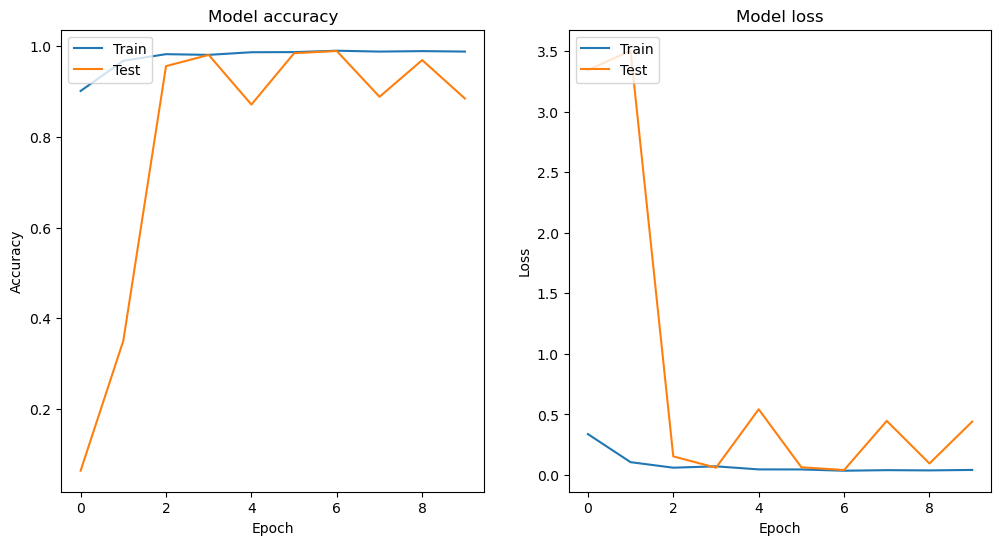

In [45]:
model.load_weights('best_model.keras')

train_loss, train_acc = model.evaluate(train_generator)
val_loss, val_acc = model.evaluate(test_generator)

print(f'Train accuracy: {train_acc:.4f}, Test accuracy: {val_acc:.4f}')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()
